In [1]:
import os
import numpy as np
from qiskit import*
from qiskit import transpile,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import Aer
from qiskit.quantum_info import partial_trace
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.quantum_info import DensityMatrix
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron
large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
plt.rcParams.update(params)

In [2]:
# working directory
path =("/Users/sasankadowarah/Ultimate_QM_MM/")

"""
Identity and Pauli matrices .
"""
I2      = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

"""
Matrix for projection to |0> and |1> states.
"""
PI_0 = np.matrix([[1,0],[0,0]]) # |0><0|
PI_1 = np.matrix([[0,0],[0,1]]) # |1><1|                         

def controlled_ry_gate_matrix(angle_theta):
        def ry_matrix(angle):
                return np.matrix([[np.cos(angle/2),-np.sin(angle/2)],
                                  [np.sin(angle/2),np.cos(angle/2)]])
        return kron(PI_0,I2) + kron(PI_1,ry_matrix(angle_theta))

def controlled_not_gate_matrix():
        return kron(I2,PI_0) + kron(sigma_x,PI_1)

gamma_in = 2.6
gamma_out = 2.6

#### Hamiltonian of $H_{2}$ with Jordan Wigner transformation

In [3]:
# Define a function to convert the second column to complex numbers
def complex_converter(s):
    return complex(s.decode('utf-8'))

# loads the Jordan Wigner transformed Hamiltonian
os.chdir(path)
data = np.loadtxt("hydrogen_jw_hamiltonian.txt", delimiter='\t', converters={1: complex_converter}, dtype=object)

# Separate the data into two arrays
H_pauli_lst, H_pauli_coeff_lst = data.T

In [4]:
H_pauli_lst

array(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ',
       'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
      dtype=object)

In [5]:
H_pauli_coeff_lst

array([(-0.81054798+0j), (0.17218393+0j), (-0.22575349+0j),
       (0.17218393+0j), (-0.22575349+0j), (0.12091263+0j),
       (0.16892754+0j), (0.16614543+0j), (0.0452328+0j), (0.0452328+0j),
       (0.0452328+0j), (0.0452328+0j), (0.16614543+0j), (0.17464343+0j),
       (0.12091263+0j)], dtype=object)

In [6]:
# number of qubits
L = len(H_pauli_lst[0])

r"""

This function constructs the matrix of the Hamiltonian from the data file of Pauli strings and coefficients.

"""

def sparse_Pauli_to_dense_matrix(sparse_Pauli_matrices_lst, Pauli_matrices_coefficients):
    
    # Pauli matrices dictionary
    pauli_matrices_dict = {"I": np.array([[1,0],
                                          [0,1]]),
                  "X": np.array([[0,1],
                                 [1,0]]),
                  "Y": np.array([[0,-1j],
                                 [1j,0]]),
                  "Z": np.array([[1,0],
                                 [0,-1]])}
    
    # making the Pauli matrices sparse
    sparse_pauli_matrices_dict = {key: csr_matrix(value) for key, value in pauli_matrices_dict.items()}      

    # initialize the Hamiltonian as a sparse matrix
    sparse_hamiltonian = csr_matrix((2**L, 2**L))

    # converts a pauli string into a matrix
    def pauli_string_to_matrix(pauli_string):

        mat = sparse_pauli_matrices_dict[pauli_string[0]]
        
        for p_string in range(1,L):
           mat = kron(mat, sparse_pauli_matrices_dict[pauli_string[p_string]])
        return mat
    
    for i in range(len(sparse_Pauli_matrices_lst)):
      
      sparse_hamiltonian += Pauli_matrices_coefficients[i] * pauli_string_to_matrix(sparse_Pauli_matrices_lst[i])
      
    return sparse_hamiltonian

full_hamiltonian = sparse_Pauli_to_dense_matrix(H_pauli_lst,H_pauli_coeff_lst);

#### $n=1$ and $n=2$ states of the Hamiltonian

In [7]:
# n = 1 basis states 0001,0010,0100,1000
def ket_from_binary_string(binary_string):
        bin_dict = {"0":np.matrix([1,0]), "1":np.matrix([0,1])}
        b_0 = bin_dict[binary_string[-1]]
        for b in range(len(binary_string)-2,-1,-1):
                b_0 = kron(bin_dict[binary_string[b]],b_0)
        return b_0

n_1_sector_basis_states = [ket_from_binary_string("0001"),ket_from_binary_string("0010"),ket_from_binary_string("0100"),
                           ket_from_binary_string("1000")]

n_1_sector_size = 4
H_n_1_sector = np.zeros((n_1_sector_size,n_1_sector_size),dtype=np.complex128)

for m in range(len(n_1_sector_basis_states)):
        for n in range(len(n_1_sector_basis_states)):
                ket_m = n_1_sector_basis_states[m]
                ket_n = n_1_sector_basis_states[n]
                H_n_1_sector[m,n] = (ket_m *full_hamiltonian* ket_n.T).A[0,0]


# n = 2 basis states 0011,0101,0110,1001,1010,1100
n_2_sector_basis_states = [ket_from_binary_string("0011"),ket_from_binary_string("0101"),ket_from_binary_string("0110"),
                           ket_from_binary_string("1001"),ket_from_binary_string("1010"),
                           ket_from_binary_string("1100")]

n_2_sector_size = 6
H_n_2_sector = np.zeros((n_2_sector_size,n_2_sector_size),dtype=np.complex128)

for m in range(len(n_2_sector_basis_states)):
        for n in range(len(n_2_sector_basis_states)):
                ket_m = n_2_sector_basis_states[m]
                ket_n = n_2_sector_basis_states[n]
                H_n_2_sector[m,n] = (ket_m *full_hamiltonian* ket_n.T).A[0,0]

In [8]:
n_2_eigvals, n_2_eigstates = np.linalg.eigh(H_n_2_sector)
#n_2_eigvals, np.around(n_2_eigstates,2)

In [9]:
n_1_eigvals, n_1_eigstates = np.linalg.eigh(H_n_1_sector)
#n_1_eigvals, n_1_eigstates

#### One time step circuit for trotterization

In [10]:
"""

The list of Pauli strings is 
'IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ',
'ZIIZ','YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'

"""


def one_time_step_circuit(dt,barrier_status):
    
    # Existing quantum registers
    qr = QuantumRegister(L,"q")
    anc = QuantumRegister(1,r"\rm{ancilla}")


    # Create a new quantum circuit with the classical register
    qc_h2 = QuantumCircuit(anc,qr)    

    """
    We will ignore the term IIII as it does nothing to the wavefunction.
    """

    """
    Pauli strings with one Z gate and rest identity matrix. They can be executed in parallel
    if acting on different qubits.
    """
    # 1,2,3,4
    qc_h2.rz(2*H_pauli_coeff_lst[1].real*dt,qr[0]) # IIIZ
    qc_h2.rz(2*H_pauli_coeff_lst[2].real*dt,qr[1]) # IIZI
    qc_h2.rz(2*H_pauli_coeff_lst[3].real*dt,qr[2]) # IZII
    qc_h2.rz(2*H_pauli_coeff_lst[4].real*dt,qr[3]) # ZIII

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    """
    Pauli strings with two Z gates and two identities.
    """
    # 5,6,7,12,13,14

    # IIZZ 5
    qc_h2.cx(qr[0],qr[1])
    qc_h2.rz(2*H_pauli_coeff_lst[5].real*dt,qr[1])
    qc_h2.cx(qr[0],qr[1])
    
    # ZZII 14    
    qc_h2.cx(qr[2],qr[3])
    qc_h2.rz(2*H_pauli_coeff_lst[14].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])   

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # IZIZ 6
    qc_h2.swap(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])
    qc_h2.rz(2*H_pauli_coeff_lst[6].real*dt,qr[1])
    qc_h2.cx(qr[0],qr[1])    
    qc_h2.swap(qr[1],qr[2])   
    
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # ZIZI 13
    qc_h2.swap(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.rz(2*H_pauli_coeff_lst[13].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])     
    qc_h2.swap(qr[1],qr[2])

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # ZIIZ 7 
    qc_h2.swap(qr[3],qr[2])
    qc_h2.swap(qr[2],qr[1])        
    qc_h2.cx(qr[0],qr[1])
    qc_h2.rz(2*H_pauli_coeff_lst[7].real*dt,qr[1])
    qc_h2.cx(qr[0],qr[1])     
    qc_h2.swap(qr[2],qr[1])       
    qc_h2.swap(qr[3],qr[2]) 
    
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass
    
    # IZZI 12
    qc_h2.cx(qr[1],qr[2])
    qc_h2.rz(2*H_pauli_coeff_lst[12].real*dt,qr[2])
    qc_h2.cx(qr[1],qr[2])

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # XXXX 11
    for i in range(L):
        qc_h2.h(qr[i])

    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[11].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])

    for i in range(L):
        qc_h2.h(qr[i])   
        
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass   

    # YYYY 8
    for i in range(L):
        qc_h2.sdg(qr[i])    
    for i in range(L):
        qc_h2.h(qr[i])  

    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[8].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])

    for i in range(L):
        qc_h2.h(qr[i])  
    for i in range(L):
        qc_h2.sdg(qr[i])  

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass   

    # XXYY 9
    qc_h2.sdg(qr[0])
    qc_h2.h(qr[0])
    qc_h2.sdg(qr[1])
    qc_h2.h(qr[1])   
    qc_h2.h(qr[2])
    qc_h2.h(qr[3])

    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[9].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])   

    qc_h2.h(qr[0])
    qc_h2.sdg(qr[0])
    qc_h2.h(qr[1]) 
    qc_h2.sdg(qr[1])  
    qc_h2.h(qr[2])
    qc_h2.h(qr[3])     

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # YYXX 10
    qc_h2.sdg(qr[2])
    qc_h2.h(qr[2])
    qc_h2.sdg(qr[3])
    qc_h2.h(qr[3])   
    qc_h2.h(qr[0])
    qc_h2.h(qr[1])    
    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[10].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])
    qc_h2.h(qr[2])  
    qc_h2.sdg(qr[2])
    qc_h2.h(qr[3])   
    qc_h2.sdg(qr[3])
    qc_h2.h(qr[0])
    qc_h2.h(qr[1])

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # ancilla qubit

    # L_out
    theta_out = 2*np.arcsin(np.sqrt(dt*gamma_out))
    qc_h2.initialize([1,0],anc[0])
    qc_h2.cry(theta_out,qr[0],anc)
    qc_h2.cx(anc,qr[0])
    qc_h2.initialize([1,0],anc)    
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass        
    # L_in
    qc_h2.x(qr[0])
    theta_in = 2*np.arcsin(np.sqrt(dt*gamma_in))
    qc_h2.cry(theta_in,qr[0],anc)
    qc_h2.cx(anc,qr[0])
    qc_h2.x(qr[0])
    qc_h2.initialize([1,0],anc)
    return qc_h2
#one_time_step_circuit(0.1,True).draw("mpl",style="iqp",scale=1)#.savefig("H2_Lindbladian_circuit_not_optimized.jpg",dpi=200)

#### Complete trotter circuit for time evolution

In [11]:
def time_evolved_density_matrix(time_step,final_time,initial_state):

    number_of_iterations = int(final_time/time_step)

    #print("Number of Floquet cycles = ", number_of_iterations)

    transpiled_one_step_circuit = transpile(one_time_step_circuit(time_step,False), basis_gates = ["rz","cx","h",], optimization_level=2)

    # Existing quantum registers
    qr = QuantumRegister(L,"q")
    anc = QuantumRegister(1,"ancilla")

    # Add a classical register
    cr = ClassicalRegister(L,"c")
    # Create a new quantum circuit with the classical register
    qc = QuantumCircuit(anc,qr, cr)

    # system is initialized at the user defined state
    qubit_dict = {"1":[0,1],"0":[1,0]}

    r"""
        The initial state is assigned in reverse order because of qiskit's convention
        of counting from right to left. So the first value of the initial state string
        is assigned to the bottom qubit and the last value of the initial state string
        is assigned to the top qubit!
    """

    qc.initialize(qubit_dict[initial_state[3]],qr[0])
    qc.initialize(qubit_dict[initial_state[2]],qr[1])
    qc.initialize(qubit_dict[initial_state[1]],qr[2])
    qc.initialize(qubit_dict[initial_state[0]],qr[3])

    for _ in range(number_of_iterations):
        qc = qc.compose(transpiled_one_step_circuit)

    """qc.measure(anc,cr[4])
    qc.measure(qr[3], cr[3])   
    qc.measure(qr[2], cr[2])
    qc.measure(qr[1], cr[1])
    qc.measure(qr[0], cr[0])"""

    #print("Circuit depth = ",qc.depth())
    #qc.measure_all()
    return qc
#time_evolved_density_matrix(0.1,0.1,"0100").draw("mpl",style="iqp",scale=2)

#### $I_{\rm in}$ in terms of Pauli operators

In [12]:
r"""

This function returns the product of any two given Pauli matrices.
Input: pauli_matrix_1;pauli_matrix_2
Output: coefficent in front, product of Pauli matrix 1 and 2
for example for X and Y it will return the pair 1j,Z.

"""
def pauli_product(pauli_i,pauli_j): # verified for all possible combinations

        I2 = np.array([[1,0],[0,1]])
        sigma_x =np.array([[0,1],[1,0]])
        sigma_y = np.array([[0,-1j],[1j,0]])
        sigma_z = np.array([[1,0],[0,-1]])

        pauli_matrices_dict = {"I":I2, "X":sigma_x, "Y": sigma_y, "Z": sigma_z}

        pauli_product = pauli_matrices_dict[pauli_i]@pauli_matrices_dict[pauli_j]

        b_0 = np.trace(I2@pauli_product)/2
        b_x = np.trace(sigma_x@pauli_product)/2
        b_y = np.trace(sigma_y@pauli_product)/2
        b_z = np.trace(sigma_z@pauli_product)/2

        pauli_list = np.array(["I","X","Y","Z"])
        coeff_lst = np.array([b_0,b_x,b_y,b_z])

        non_zero_coeff = np.nonzero(coeff_lst)

        return coeff_lst[non_zero_coeff][0], pauli_list[non_zero_coeff][0]

r"""

This function takes the hamiltonian in terms of Pauli strings and their coefficients and multiply
it by another Pauli matrix from either left or from right and returns the result. This is used
to calculate terms in the current like L^{\dagger}_{1}HL_{1}.

"""

def hamiltonian_product_pauli(original_hamiltonian_pauli_lst, original_hamiltonian_pauli_coeff, pauli_matrix_to_multiply, action_direction):

        new_hamiltonian_pauli_lst = []
        new_hamiltonian_pauli_coeff = []        

        if action_direction == "left":

                for i in range(len(original_hamiltonian_pauli_lst)):

                        pauli_strings = original_hamiltonian_pauli_lst[i]
                        pauli_coeff  = original_hamiltonian_pauli_coeff[i]

                        """
                        The given Pauli matrix will be multiplied to the fourth qubit of each Pauli string in
                        the Hamiltonian. This is because L_1 = IIIS^{(0)}_{-}. The Pauli matrix in the original
                        string in zero th position is the Lth position.
                        """
                        operator_on_qubit_0 = pauli_strings[-1]

                        # pauli matrix multiplied from left
                        new_pauli_product = pauli_product(pauli_matrix_to_multiply,operator_on_qubit_0)

                        # updating the Pauli string
                        new_hamiltonian_pauli_lst.append(pauli_strings[0:L-1]+new_pauli_product[1])

                        # updating the Pauli coefficient
                        new_hamiltonian_pauli_coeff.append(pauli_coeff*new_pauli_product[0])

        elif action_direction == "right":

                for i in range(len(original_hamiltonian_pauli_lst)):

                        pauli_strings = original_hamiltonian_pauli_lst[i]
                        pauli_coeff  = original_hamiltonian_pauli_coeff[i]

                        """
                        The given Pauli matrix will be multiplied to the fourth qubit of each Pauli string in
                        the Hamiltonian. This is because L_1 = IIIS^{(0)}_{-}. The Pauli matrix in the original
                        string in zero th position is the Lth position.
                        """
                        operator_on_qubit_0 = pauli_strings[-1]

                        # pauli matrix multiplied from right
                        new_pauli_product = pauli_product(operator_on_qubit_0,pauli_matrix_to_multiply)

                        # updating the Pauli string
                        new_hamiltonian_pauli_lst.append(pauli_strings[0:L-1]+new_pauli_product[1])

                        # updating the Pauli coefficient
                        new_hamiltonian_pauli_coeff.append(pauli_coeff*new_pauli_product[0])

        return new_hamiltonian_pauli_lst, new_hamiltonian_pauli_coeff              

r"""

This function takes pairs each with a string of Pauli matrices and coefficents and add the
coefficients of the Pauli strings common to both the element in the pair.
For example, input: (["IXII","IZIZ"],(a,b)) and (["YYXX","IZIZ"],(c,d)) output: ([]"IXII","YYXX","IZIZ"],(a,c,b+d))

"""

def add_similar_elements(pair1, pair2):

    dict1 = dict(zip(pair1[0], pair1[1]))
    dict2 = dict(zip(pair2[0], pair2[1]))

    all_keys = set(dict1.keys()).union(set(dict2.keys()))

    result_dict = {key: dict1.get(key, 0) + dict2.get(key, 0) for key in all_keys}

    result_pair = (list(result_dict.keys()), list(result_dict.values()))

    return result_pair 

r"""

Below each term in the I_in is evaluated separately by using the functions defined above.

"""

#L_1 = III(X-1j*Y)/2
def L_1_dag_H_L_1():

        ## (1/4) (XHX - 1j*XHY + 1j*YHX + YHY)
        # XHX
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"X","left") # XH
        h2, p2 = hamiltonian_product_pauli(h1,p1,"X","right") # XHX

        # XHY
        h3,p3 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"X","left") # XH
        h4,p4 = hamiltonian_product_pauli(h3,p3,"Y","right")  # XHY

        # YHX
        h5,p5 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Y","left") # YH
        h6,p6 = hamiltonian_product_pauli(h5,p5,"X","right")  # YHX

        # YHY
        h7,p7 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Y","left") # YH
        h8,p8 = hamiltonian_product_pauli(h7,p7,"Y","right")  # YHY

        ## adding the coefficients of similar Pauli strings
        # XHX - 1j*XHY
        h_iter_1, p_iter_1 = add_similar_elements((h2,np.array(p2)),(h4,-1j*np.array(p4)))  
        # XHX - 1j*XHY + 1j*YHX
        h_iter_2, p_iter_2 = add_similar_elements((h_iter_1,p_iter_1),(h6,1j*np.array(p6)))
        # XHX - 1j*XHY + 1j*YHX + YHY
        h_iter_3, p_iter_3 = add_similar_elements((h_iter_2,p_iter_2),(h8,np.array(p8)))

        return h_iter_3, (1/4)*np.array(p_iter_3)


def H_L1_dag_L1():

        ## H L1_dag L_1 = (1/2)*(HI + HZ)

        # H*I
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"I","right")
        # HZ
        h2,p2 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Z","right")

        h_iter_1, p_iter_1 = add_similar_elements((h1,np.array(p1)),(h2,np.array(p2)))

        return h_iter_1, (1/2)*np.array(p_iter_1)

def L_1_dag_L_1_H():

        # L1_dag L_1 H = (1/2)*(H + ZH)

        # I*H
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"I","left")
        # ZH
        h2,p2 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Z","left")

        h_iter_1, p_iter_1 = add_similar_elements((h1,np.array(p1)),(h2,np.array(p2)))

        return h_iter_1, (1/2)*np.array(p_iter_1)

# L_1_dag_H_L_1 - (1/2)*H_L1_dag_L1
I_in_term_1_term_2 = add_similar_elements((L_1_dag_H_L_1()[0],L_1_dag_H_L_1()[1]),(H_L1_dag_L1()[0],(-1/2)*np.array(H_L1_dag_L1()[1])))

# L_1_dag_H_L_1 - (1/2)*H_L1_dag_L1 - (1/2)*L_1_dag_L_1_H
I_in_term_1_term_2_term_3 = add_similar_elements((I_in_term_1_term_2[0],I_in_term_1_term_2[1]),(L_1_dag_L_1_H()[0],(-1/2)*np.array(L_1_dag_L_1_H()[1])))

#L_2 = III(X+1j*Y)/2
def L_2_dag_H_L_2():

        ## (1/4) (XHX + 1j*XHY - 1j*YHX + YHY)
        # XHX
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"X","left") # XH
        h2, p2 = hamiltonian_product_pauli(h1,p1,"X","right") # XHX

        # XHY
        h3,p3 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"X","left") # XH
        h4,p4 = hamiltonian_product_pauli(h3,p3,"Y","right")  # XHY

        # YHX
        h5,p5 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Y","left") # YH
        h6,p6 = hamiltonian_product_pauli(h5,p5,"X","right")  # YHX

        # YHY
        h7,p7 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Y","left") # YH
        h8,p8 = hamiltonian_product_pauli(h7,p7,"Y","right")  # YHY

        ## adding the coefficients of similar Pauli strings
        # XHX + 1j*XHY
        h_iter_1, p_iter_1 = add_similar_elements((h2,np.array(p2)),(h4,1j*np.array(p4)))  
        # XHX + 1j*XHY - 1j*YHX
        h_iter_2, p_iter_2 = add_similar_elements((h_iter_1,p_iter_1),(h6,-1j*np.array(p6)))
        # XHX + 1j*XHY - 1j*YHX + YHY
        h_iter_3, p_iter_3 = add_similar_elements((h_iter_2,p_iter_2),(h8,np.array(p8)))

        return h_iter_3, (1/4)*np.array(p_iter_3)

def H_L2_dag_L2():

        ## H L2_dag L_2 = (1/2)*(HI - HZ)

        # HI
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"I","right")
        # HZ
        h2,p2 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Z","right")

        h_iter_1, p_iter_1 = add_similar_elements((h1,np.array(p1)),(h2,-np.array(p2)))

        return h_iter_1, (1/2)*np.array(p_iter_1)

def L_2_dag_L_2_H():

        # L2_dag L_2 H = (1/2)*(IH - ZH)

        # IH
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"I","left")
        # ZH
        h2,p2 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Z","left")
        
        h_iter_1, p_iter_1 = add_similar_elements((h1,np.array(p1)),(h2,-np.array(p2)))

        return h_iter_1, (1/2)*np.array(p_iter_1)

# L_2_dag_H_L_2 - (1/2)*H_L2_dag_L2
I_out_term_1_term_2 = add_similar_elements((L_2_dag_H_L_2()[0],L_2_dag_H_L_2()[1]),(H_L2_dag_L2()[0],(-1/2)*np.array(H_L2_dag_L2()[1])))

# L_2_dag_H_L_2 - (1/2)*H_L2_dag_L2 - (1/2)*L_2_dag_L_2_H
I_out_term_1_term_2_term_3 = add_similar_elements((I_out_term_1_term_2[0],I_out_term_1_term_2[1]),(L_2_dag_L_2_H()[0],(-1/2)*np.array(L_2_dag_L_2_H()[1])))        

In [13]:
"""h_intermediate_pauli_lst = hamiltonian_product_pauli(H_pauli_lst, H_pauli_coeff_lst, "Y", "left")[0]
h_intermediate_pauli_coefficient = hamiltonian_product_pauli(H_pauli_lst, H_pauli_coeff_lst, "Y", "left")[1]

h_pauli_lst = hamiltonian_product_pauli(h_intermediate_pauli_lst, h_intermediate_pauli_coefficient, "Y", "right")[0]
h_pauli_coefficient = hamiltonian_product_pauli(h_intermediate_pauli_lst, h_intermediate_pauli_coefficient, "Y", "right")[1]

h_pauli_coefficient+H_pauli_coeff_lst""";

In [14]:
# Unpack the pair into two lists
list1, list2 = I_in_term_1_term_2_term_3

# Use a list comprehension to filter the elements where the corresponding element in the second list is not 0 or 0j
filtered_I_in_term_1_term_2_term_3 = ([x for x, y in zip(list1, list2) if y != 0j], [y for y in list2 if y != 0j])

In [15]:
# Unpack the pair into two lists
list1, list2 = I_out_term_1_term_2_term_3

# Use a list comprehension to filter the elements where the corresponding element in the second list is not 0 or 0j
filtered_I_out_term_1_term_2_term_3 = ([x for x, y in zip(list1, list2) if y != 0j], [y for y in list2 if y != 0j])

#### Noise model for the simulator

In [16]:
T1_noise = 213.07e3
T2_noise = 115.57e3

T1_standard_deviation = T1_noise/4
T2_standard_deviation = T2_noise/4

# T1 and T2 values for qubits 0-3
T1s = np.random.normal(T1_noise, T1_standard_deviation, L+1) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(T2_noise, T2_standard_deviation, L+1)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(L+1)])

# Instruction times (in nanoseconds)
time_u1         = 0   # virtual gate
time_u2         = 50  # (single X90 pulse)
time_u3         = 100 # (two X90 pulses)
time_sx         = 100
time_cx         = 300
time_reset      = 1000  # 1 microsecond
time_measure    = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_sx  = [thermal_relaxation_error(t1, t2, time_sx)
              for t1, t2 in zip(T1s, T2s)]              
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]
errors_ecr = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]               

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(L+1):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_sx[j], "sx",[j])
    noise_thermal.add_quantum_error(errors_sx[j], "rz",[j])
    #noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    #noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    #noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(L+1):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
        noise_thermal.add_quantum_error(errors_ecr[j][k], "ecr", [j, k])   
print(noise_thermal)    

NoiseModel:
  Basis gates: ['cx', 'ecr', 'id', 'rz', 'sx']
  Instructions with noise: ['measure', 'rz', 'reset', 'sx', 'cx', 'ecr']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('rz', (0,)), ('rz', (1,)), ('rz', (2,)), ('rz', (3,)), ('rz', (4,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 4)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (2, 4)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3)), ('cx', (3, 4)), ('cx', (4, 0)), ('cx', (4, 1)), ('cx', (4, 2)), ('cx', (4, 3)), ('cx', (4, 4)), ('ecr', (0, 0)), ('ecr', (0, 1)), ('ecr', (0, 2)), ('ecr', (0, 3)), ('ecr', (0, 4)), 

#### Trotterization of the system

In [17]:
r"""

 This function appends a H gate for X measurement and S_{\dagger}*H gate for Y measurement.

"""

def pauli_string_basis_change_circuit(observable_string):
    
    # Existing quantum registers
    qr = QuantumRegister(L,"q")
    anc = QuantumRegister(1,"ancilla")

    # Add a classical register
    cr = ClassicalRegister(L,"c")
    
    # Create a new quantum circuit with the classical register
    qc_basis_change = QuantumCircuit(anc,qr, cr)

    # reversing the pauli string so that the rightmost qubit is counted as zeroth qubit
    observable_string = observable_string[::-1]
    
    for i in range(L):

        if observable_string[i] == "I":
            pass
        elif observable_string[i] == "Z":
            pass
        elif observable_string[i] == "X":
            qc_basis_change.h(qr[i])
        elif observable_string[i] == "Y":
            qc_basis_change.sdg(qr[i])
            qc_basis_change.h(qr[i])

    #qc_basis_change.measure(anc,cr[4])
    qc_basis_change.measure(qr[3], cr[3])   
    qc_basis_change.measure(qr[2], cr[2])
    qc_basis_change.measure(qr[1], cr[1])
    qc_basis_change.measure(qr[0], cr[0])  

    return qc_basis_change

#pauli_string_1 = filtered_I_out_term_1_term_2_term_3[0][7]
#print(pauli_string_1)    
#pauli_string_basis_change_circuit(pauli_string_1).draw("mpl", style= "iqp",scale=2)

In [18]:
r"""

This function takes a Pauli string as input and returns the counts from noisy model.

"""

def trotter_simulation_and_return_counts(pauli_string_to_calculate_expectation_value,
                                         time_step_for_trotterization,
                                         initial_state_of_system,
                                         t_final,
                                         number_of_shots,
                                         ):
        
        # constructs the trotter circuit and prepares the density matrix
        trotter_circuit = time_evolved_density_matrix(time_step_for_trotterization,
                                                      t_final,
                                                      initial_state_of_system)

        # composes necessary basis change to measures pauli operators X and Y if exists in pauli string
        trotter_circuit = trotter_circuit.compose(pauli_string_basis_change_circuit(pauli_string_to_calculate_expectation_value))

        sim_thermal = AerSimulator(noise_model=noise_thermal)
        #sim_thermal = Aer.get_backend("qasm_simulator")

        basis_set_1 = ["cx","rz","h"]
        basis_set_2 = ["ecr","id","rz","sx","x"]
        transpiled_trotter_circuit = transpile(trotter_circuit, sim_thermal, basis_gates = basis_set_1 ,optimization_level = 2)

        result_thermal = sim_thermal.run(transpiled_trotter_circuit, shots = number_of_shots).result()

        counts_thermal = result_thermal.get_counts()

        return counts_thermal

In [19]:
I_in_pauli_list = filtered_I_in_term_1_term_2_term_3[0]
I_in_coefficients = filtered_I_in_term_1_term_2_term_3[1]

I_out_pauli_list = filtered_I_out_term_1_term_2_term_3[0]
I_out_coefficients = filtered_I_out_term_1_term_2_term_3[1]

In [62]:
number_of_shots = 8192
r"""

This function calculates the expectation value of each pauli string in the current in and current out operator.

Input: List of Pauli strings to calculate expectation value 
e.g. ["XXYY", "IZIZ"]
Output: List of expectation values of each Pauli string in the input list
e.g. [Expectation value("XXYY"), Expectation value("IZIZ")]

"""

def expectation_value_of_pauli_string_from_counts(pauli_string, counts_dictionary_from_measurement):

        pauli_string_expectation_value = 0.0
        non_identity_indices = [i for i, char in enumerate(pauli_string) if char != "I"]
        for key, value in counts_dictionary_from_measurement.items():
                filtered_binary_string = "".join([char for i, char in enumerate(key) if i in non_identity_indices])
                pauli_string_expectation_value += ((-1)**sum(int(num) for num in filtered_binary_string))* (value/number_of_shots)
        return pauli_string_expectation_value

def current_expectation_value(current_operator_pauli_strings, time):

        current_expectation_value_lst = []

        for pauli_string in current_operator_pauli_strings:

                # simulating a circuit with the Pauli string
                bit_strings_and_counts = trotter_simulation_and_return_counts(pauli_string,
                                                0.1,"0100",time,number_of_shots)


                # calculating the expectation value of the Pauli string from counts       
                pauli_string_expectation_value = expectation_value_of_pauli_string_from_counts(pauli_string, bit_strings_and_counts)

                current_expectation_value_lst.append(pauli_string_expectation_value)                                

        return current_expectation_value_lst

In [21]:
"""def X_H_X():
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"X","left") # XH
        h2, p2 = hamiltonian_product_pauli(h1,p1,"X","right") # XHX
        return h2, p2

def Y_H_Y():
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Y","left") # YH
        h2, p2 = hamiltonian_product_pauli(h1,p1,"Y","right") # YHY       
        return h2, p2
simplified_term_1_term_2 = add_similar_elements(( X_H_X()[0],np.array( X_H_X()[1])),(Y_H_Y()[0],np.array(Y_H_Y()[1])))

simplified_term_1_term_2_term_3 = add_similar_elements((simplified_term_1_term_2[0],1/2*np.array(simplified_term_1_term_2[1])),(H_pauli_lst, -H_pauli_coeff_lst))
# Unpack the pair into two lists
list1, list2 = simplified_term_1_term_2_term_3

# Use a list comprehension to filter the elements where the corresponding element in the second list is not 0 or 0j
simplified_I_total_term_1_term_2_term_3 = ([x for x, y in zip(list1, list2) if y != 0j], [y for y in list2 if y != 0j])""";

#### Current vs time plot

In [22]:
"""time_lst = np.linspace(0.1,20,5)

for time in time_lst:        
        t = current_expectation_value(simplified_I_total_term_1_term_2_term_3[0], time)
        os.chdir("/Users/sasankadowarah/Ultimate_QM_MM/current_data_folder")
        np.save("t_"+str(np.around(time,2))+".npy",t)""";

In [23]:
"""I_tot_expectation_value_as_a_function_of_time_lst = []
for time in time_lst:

        t_load = np.load("t_"+str(np.around(time,2))+".npy",allow_pickle=True)
        
        I_tot_time = 0.0

        for i in range(len(t_load)):
                I_tot_time += simplified_I_total_term_1_term_2_term_3[1][i]*t_load[i]

        I_tot_expectation_value_as_a_function_of_time_lst.append(I_tot_time)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)        
plt.plot(time_lst, gamma_in*np.array(I_tot_expectation_value_as_a_function_of_time_lst).real)
plt.scatter(time_lst, gamma_in*np.array(I_tot_expectation_value_as_a_function_of_time_lst).real)
plt.savefig("I_total.jpg",dpi=300)
plt.show()""";

In [63]:
time_lst = np.linspace(0.0,10,5)

for time in time_lst:
        print(time)    
        t = current_expectation_value(I_in_pauli_list, time)
        os.chdir("/Users/sasankadowarah/Ultimate_QM_MM/current_data_folder")
        np.save("t_"+str(np.around(time,2))+".npy",t)

0.0
2.5
5.0
7.5
10.0


In [64]:
I_in_expectation_value_as_a_function_of_time_lst = []
I_out_expectation_value_as_a_function_of_time_lst = []

for time in time_lst:

        t_load = np.load("t_"+str(np.around(time,2))+".npy",allow_pickle=True)
        
        I_in_time = 0.0
        I_out_time = 0.0

        for i in range(len(t_load)):
                I_in_time += I_in_coefficients[i]*t_load[i]
                I_out_time += I_out_coefficients[i]*t_load[i]

        I_in_expectation_value_as_a_function_of_time_lst.append(I_in_time)
        I_out_expectation_value_as_a_function_of_time_lst.append(I_out_time) 

I_in_expectation_value_as_a_function_of_time_lst = gamma_in*np.array(I_in_expectation_value_as_a_function_of_time_lst)     
I_out_expectation_value_as_a_function_of_time_lst = gamma_out*np.array(I_out_expectation_value_as_a_function_of_time_lst)

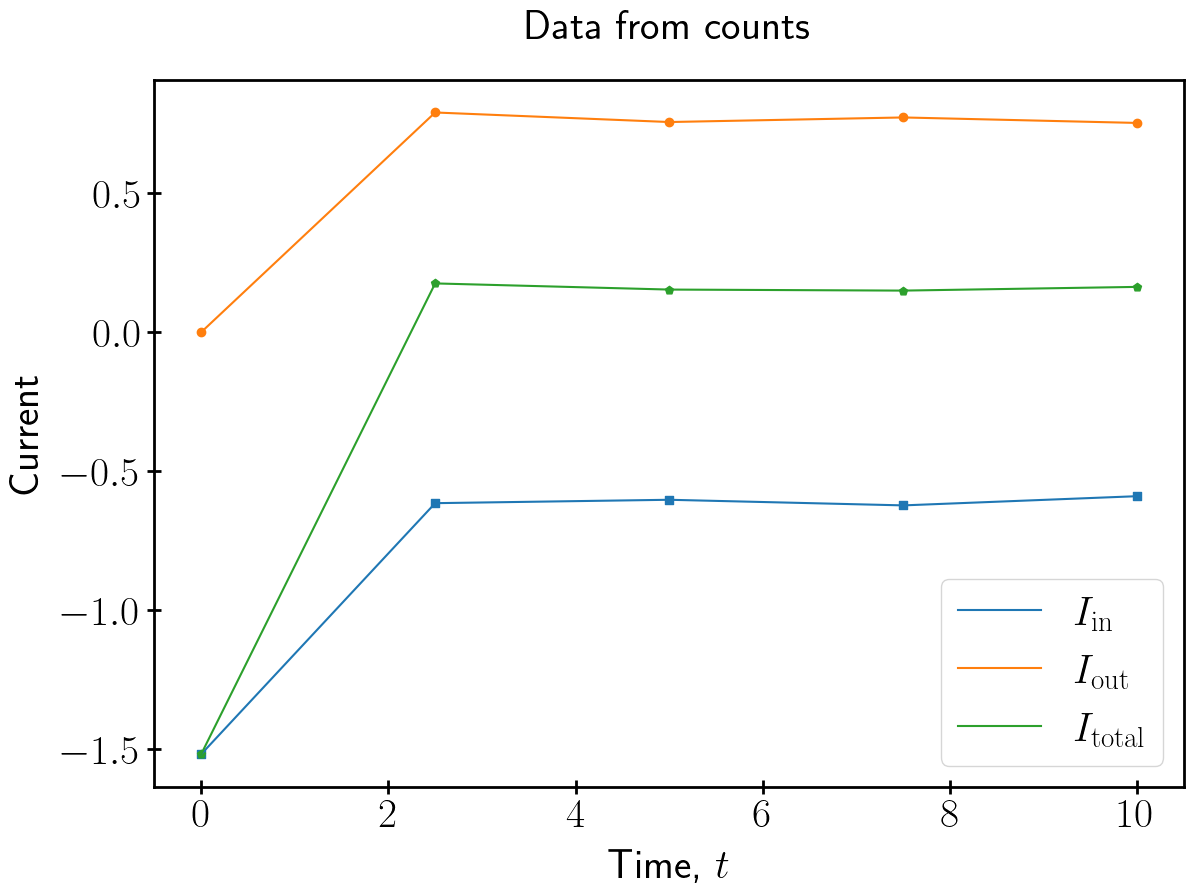

In [73]:
MarkerSize = 400
LineWidth = 5
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(9)
plt.scatter(time_lst,I_in_expectation_value_as_a_function_of_time_lst.real,marker = "s")
plt.scatter(time_lst,I_out_expectation_value_as_a_function_of_time_lst.real,marker = "o")
plt.scatter(time_lst,I_in_expectation_value_as_a_function_of_time_lst.real+I_out_expectation_value_as_a_function_of_time_lst.real,marker = "p")
plt.plot(time_lst,I_in_expectation_value_as_a_function_of_time_lst.real,label=r"$I_{\rm in}$")
plt.plot(time_lst,I_out_expectation_value_as_a_function_of_time_lst.real,label=r"$I_{\rm out}$")
plt.plot(time_lst,I_in_expectation_value_as_a_function_of_time_lst.real+I_out_expectation_value_as_a_function_of_time_lst.real,label=r"$I_{\rm total}$")
plt.legend()
plt.ylabel(r"Current",labelpad=10)
plt.xlabel(r"Time, $t$",labelpad=10)
f.tight_layout(pad=1.0)
ax = f.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.gcf().subplots_adjust(bottom=0.2)
plt.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
plt.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
plt.title("Data from counts")
#plt.ylim(-0.05,0.05)
plt.savefig("I_in_I_out_I_total_counts.jpg",dpi=300)
plt.show()

## Current measurement from density matrix measurement

In [38]:
time_step_for_trotterization = 0.1
initial_state_of_system = "0100"
time_lst = np.linspace(0.0,10,5)
counts_lst = []
density_matrices_lst = []

sim_thermal = Aer.get_backend("qasm_simulator")
#sim_thermal = AerSimulator(noise_model=noise_thermal)

basis_set_1 = ["rz","cx","h"]
basis_set_2 = ["ecr","id","rz","sx","x"]

I_in_expectation_value = []
density_matrices_lst = []

for time in time_lst:
        print(time)
        # contstructs the time evolved density matrix quantum circuit
        h_2_molecule_circuit = time_evolved_density_matrix(time_step_for_trotterization,time,initial_state_of_system)
                
        # transpile the circuit
        circ_tthermal = transpile(h_2_molecule_circuit, sim_thermal, basis_gates = basis_set_2 ,optimization_level = 2)
        
        """
        Qiskit counts the qubits from left to right while calculating the density matrix as opposed to its
        normal convention of counting from right to left. So we reverse the qubit order.
        """
        
        density_matrix = DensityMatrix.from_instruction(circ_tthermal)#.reverse_qargs()

        density_matrices_lst.append(density_matrix)

0.0
2.5
5.0
7.5
10.0


#### Current in and out plot

In [58]:
# sigma_- acting on the first qubit
L_in  = kron(I2,kron(I2,kron(I2,(sigma_x - 1j*sigma_y)/2)))
L_out = kron(I2,kron(I2,kron(I2,(sigma_x + 1j*sigma_y)/2)))

#L_in  = kron(sigma_z,kron(sigma_z,kron(sigma_z,(sigma_x - 1j*sigma_y)/2)))
#L_out = kron(sigma_z,kron(sigma_z,kron(sigma_z,(sigma_x + 1j*sigma_y)/2)))

# energy currents definition
def I_in(hamiltonian, density_matrix):
        return gamma_in*np.trace(( (L_in.conj().T)@hamiltonian@L_in
                - (1/2)*hamiltonian@(L_in.conj().T)@L_in
                - (1/2)*(L_in.conj().T)@L_in@hamiltonian )@density_matrix)

def I_out(hamiltonian, density_matrix):
        return gamma_out*np.trace(( (L_out.conj().T)@hamiltonian@L_out
                - (1/2)*hamiltonian@(L_out.conj().T)@L_out
                - (1/2)*(L_out.conj().T)@L_out@hamiltonian )@density_matrix)

In [59]:
from qiskit.quantum_info import partial_trace
reduced_density_matrix_lst = []
for rho in density_matrices_lst:
        # tracing out the ancilla qubit which is q_0
        rho_reduced = partial_trace(rho, [0])
        reduced_density_matrix_lst.append(rho_reduced)

In [60]:
I_in_lst = []
I_out_lst = []
for rho in reduced_density_matrix_lst:
        I_in_lst.append(I_in(full_hamiltonian,rho).real)
        I_out_lst.append(I_out(full_hamiltonian,rho).real)

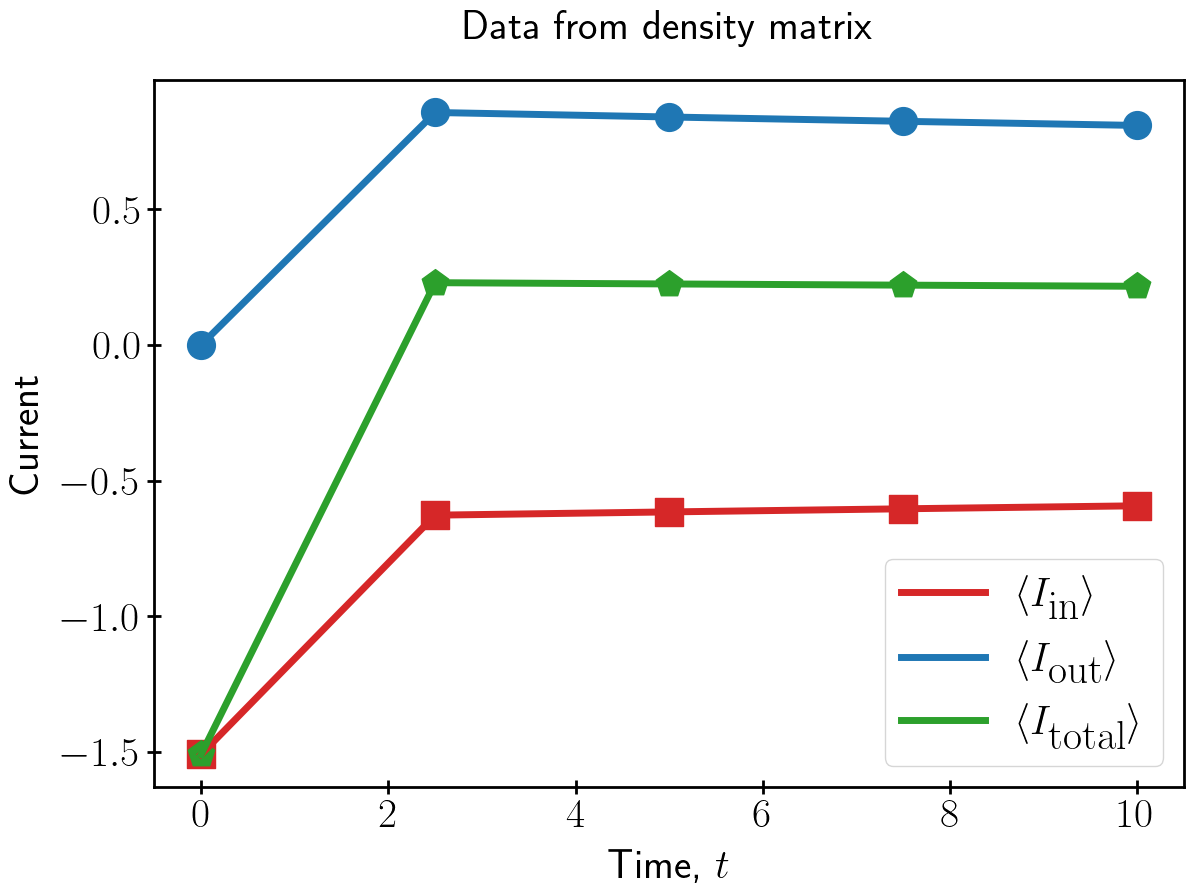

In [70]:
MarkerSize = 400
LineWidth = 5
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(9)
plt.plot(time_lst,I_in_lst,label=r"$\langle I_{\textrm{in}} \rangle$",linewidth=LineWidth,color="tab:red")
plt.scatter(time_lst,I_in_lst, s = MarkerSize, marker = "s", color="tab:red")
plt.plot(time_lst,I_out_lst,label=r"$\langle I_{\textrm{out}} \rangle$",linewidth=LineWidth,color="tab:blue")
plt.scatter(time_lst,I_out_lst, s = MarkerSize,marker = "o", color="tab:blue")
plt.plot(time_lst,np.array(I_in_lst) + np.array(I_out_lst),label=r"$\langle I_{\textrm{total}} \rangle $",linewidth=LineWidth,color="tab:green")
plt.scatter(time_lst,np.array(I_in_lst) + np.array(I_out_lst), s = MarkerSize, marker = "p", color="tab:green")
#plt.axhline(y=0.0, color="k", linestyle='--')
#plt.title(r"$\gamma_{1} = $"+str(gamma_in)+"$, \gamma_{2} = $"+str(gamma_out)+" , dt ="+str(time_step_for_trotterization)+"$, T_{1} = $"+str(np.around(T1_noise/1.e3,2))+ "$ \mu$ s" +"$, T_{2} = $"+str(np.around(T2_noise/1.e3,2))+"$\mu$ s")
plt.ylabel(r"Current",labelpad=10)
plt.xlabel(r"Time, $t$",labelpad=10)
f.tight_layout(pad=1.0)
ax = f.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.gcf().subplots_adjust(bottom=0.2)
plt.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
plt.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
plt.legend()
plt.title("Data from density matrix")
#plt.ylim([-2,1.5])
#plt.savefig("current_vs_time_"+str(gamma_in)+"_"+str(gamma_out)+"_"+str(initial_state_of_system)+"_"+str(np.around(T1_noise/1.e3,2))+"_"+str(np.around(T2_noise/1.e3,2))+".jpg", dpi=300)
plt.savefig("I_in_I_out_I_total_density_matrix.jpg",dpi=300)
plt.show()

In [55]:
"""# System Specification
n_qubits = 2
circ = QuantumCircuit(n_qubits)
circ.initialize([1,0],0)
# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
#circ.draw("mpl",style="iqp",scale=2)

#sim_thermal = AerSimulator(noise_model=noise_thermal)
sim_thermal = Aer.get_backend("qasm_simulator")

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal,basis_gates = ["ecr","id","rz","sx","x"])

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal, shots = 8192).result()
counts_thermal = result_thermal.get_counts()
statevector = counts_to_statevector(counts_thermal)
print("Statevector = ",statevector)
print("\n")
density_matrix = np.outer(statevector, np.conj(statevector))
print("Density matrix = ",density_matrix)""";

In [56]:
"""# System Specification
n_qubits = 2
circ = QuantumCircuit(n_qubits)
circ.initialize([1,0],0)
# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
#sim_thermal = AerSimulator(noise_model=noise_thermal)    
sim_thermal = Aer.get_backend("qasm_simulator")
circ_tthermal = transpile(circ, sim_thermal,basis_gates = ["ecr","id","rz","sx","x"],optimization_level=2)
density_matrix = DensityMatrix.from_instruction(circ_tthermal)
print(density_matrix)
circ.draw("mpl",style="iqp",scale=2)""";

In [57]:
"""from qiskit.tools.visualization import plot_histogram
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)
#sim_thermal = Aer.get_backend("qasm_simulator")

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal,basis_gates = ["ecr","id","rz","sx","x"])

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts()

# Plot noisy output
plot_histogram(counts_thermal)""";